In [1]:
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, brier_score_loss

import matplotlib.pyplot as plt

In [2]:
parquet_files = glob.glob("data/silver_features/*.parquet")
df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)

print("Total rows:", len(df))
print("Total markets:", df["condition_id"].nunique())

Total rows: 29099
Total markets: 258


In [3]:
df["y_final"] = df["y_final"].astype(int)
df["had_trade"] = df["had_trade"].astype(int)

df["ret_1"] = df["ret_1"].fillna(0.0)
df["vol_7"] = df["vol_7"].fillna(0.0)

df["log_volume"] = np.log1p(df["volume"].astype(float))
df["log_open_interest"] = np.log1p(df["open_interest"].astype(float))
df["log_time_to_close"] = np.log1p(df["time_to_close_sec"].clip(lower=0).astype(float))

In [4]:
DAYS_BEFORE_CLOSE = 7
SECONDS_BEFORE_CLOSE = DAYS_BEFORE_CLOSE * 24 * 60 * 60

df = df[df["time_to_close_sec"] >= SECONDS_BEFORE_CLOSE].copy()

In [5]:
feature_cols = [
    "p_mkt",
    "spread",
    "log_volume",
    "log_open_interest",
    "log_time_to_close",
    "ret_1",
    "vol_7",
    "had_trade"
]

sequences = []
labels = []
groups = []

for cid, g in df.groupby("condition_id"):
    g = g.sort_values("end_period_ts")

    X_seq = g[feature_cols].values
    y = g["y_final"].iloc[0]

    sequences.append(X_seq)
    labels.append(y)
    groups.append(cid)

print("Total sequences:", len(sequences))

Total sequences: 255


In [6]:
max_len = max(len(seq) for seq in sequences)
n_features = len(feature_cols)

def pad_sequence(seq, max_len):
    pad_width = max_len - len(seq)
    return np.pad(seq, ((pad_width, 0), (0, 0)), mode="constant")

X_padded = np.stack([pad_sequence(seq, max_len) for seq in sequences])
y = np.array(labels)
groups = np.array(groups)

print("Padded shape:", X_padded.shape)

Padded shape: (255, 166, 8)


In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_padded, y, groups=groups))

X_train, X_test = X_padded[train_idx], X_padded[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train markets:", len(np.unique(groups[train_idx])))
print("Test markets:", len(np.unique(groups[test_idx])))

Train markets: 204
Test markets: 51


In [8]:
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

train_idx2, val_idx = next(
    gss_val.split(X_train, y_train, groups=groups[train_idx])
)

X_train2, X_val = X_train[train_idx2], X_train[val_idx]
y_train2, y_val = y_train[train_idx2], y_train[val_idx]

In [9]:
class MarketDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
train_ds = MarketDataset(X_train, y_train)
test_ds = MarketDataset(X_test, y_test)
val_ds = MarketDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

In [11]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        _, h = self.gru(x)
        h = h.squeeze(0)
        return torch.sigmoid(self.fc(h)).squeeze()

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [15]:
model = GRUModel(input_dim=n_features, hidden_dim=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [16]:
PATIENCE = 5 
MIN_DELTA = 1e-4

best_val_loss = np.inf
epochs_no_improve = 0
best_state_dict = None

EPOCHS = 50  # can be larger now

for epoch in range(EPOCHS):
    # ---- Training ----
    model.train()
    train_losses = []

    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # ---- Validation ----
    model.eval()
    val_losses = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            preds = model(Xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f}"
    )

    # ---- Early stopping check ----
    if best_val_loss - val_loss > MIN_DELTA:
        best_val_loss = val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

Epoch 001 | Train loss: 0.5096 | Val loss: 0.3630
Epoch 002 | Train loss: 0.4683 | Val loss: 0.3496
Epoch 003 | Train loss: 0.4281 | Val loss: 0.3451
Epoch 004 | Train loss: 0.4206 | Val loss: 0.3485
Epoch 005 | Train loss: 0.4146 | Val loss: 0.3365
Epoch 006 | Train loss: 0.4128 | Val loss: 0.3227
Epoch 007 | Train loss: 0.4009 | Val loss: 0.3171
Epoch 008 | Train loss: 0.3890 | Val loss: 0.3043
Epoch 009 | Train loss: 0.3879 | Val loss: 0.2847
Epoch 010 | Train loss: 0.3690 | Val loss: 0.3010
Epoch 011 | Train loss: 0.3660 | Val loss: 0.2648
Epoch 012 | Train loss: 0.3531 | Val loss: 0.2531
Epoch 013 | Train loss: 0.3504 | Val loss: 0.2322
Epoch 014 | Train loss: 0.3469 | Val loss: 0.2267
Epoch 015 | Train loss: 0.3395 | Val loss: 0.2389
Epoch 016 | Train loss: 0.3412 | Val loss: 0.2329
Epoch 017 | Train loss: 0.3338 | Val loss: 0.2429
Epoch 018 | Train loss: 0.3348 | Val loss: 0.2130
Epoch 019 | Train loss: 0.3371 | Val loss: 0.2986
Epoch 020 | Train loss: 0.3397 | Val loss: 0.2372


In [17]:
model.eval()
preds = []

with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(device)
        preds.append(model(Xb).cpu().numpy())

p_model = np.clip(np.concatenate(preds), 1e-6, 1-1e-6)

In [18]:
p_base = np.clip(X_test[:, -1, feature_cols.index("p_mkt")], 1e-6, 1-1e-6)

In [19]:
print("Baseline logloss:", log_loss(y_test, p_base))
print("GRU logloss:", log_loss(y_test, p_model))

print("Baseline brier:", brier_score_loss(y_test, p_base))
print("GRU brier:", brier_score_loss(y_test, p_model))

print("\nImprovements vs baseline:")
print("Δ logloss:", log_loss(y_test, p_base) - log_loss(y_test, p_model))
print("Δ brier:", brier_score_loss(y_test, p_base) - brier_score_loss(y_test, p_model))

Baseline logloss: 1.9137348963808234
GRU logloss: 0.7075693533993007
Baseline brier: 0.39749618450980395
GRU brier: 0.19658321142196655

Improvements vs baseline:
Δ logloss: 1.2061655429815228
Δ brier: 0.2009129730878374


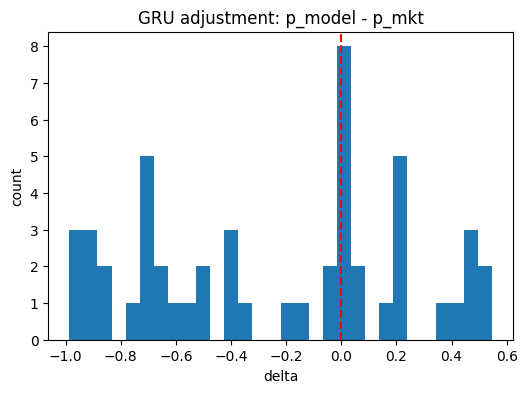

In [20]:
delta = p_model - p_base

plt.figure(figsize=(6,4))
plt.hist(delta, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("GRU adjustment: p_model - p_mkt")
plt.xlabel("delta")
plt.ylabel("count")
plt.show()

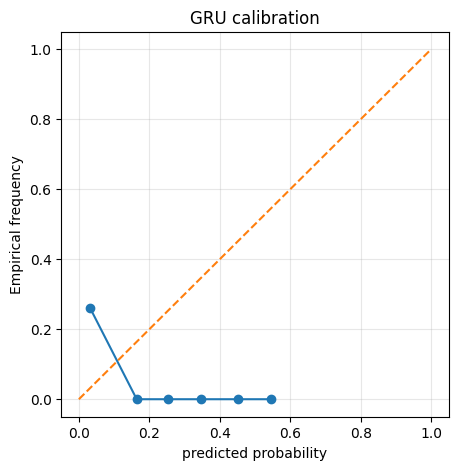

In [21]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, p_model, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("predicted probability")
plt.ylabel("Empirical frequency")
plt.title("GRU calibration")
plt.grid(alpha=0.3)
plt.show()